In [99]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [100]:
def cal_pairwise_dist(x):
    # '''计算pairwise 距离, x是matrix
    # (a-b)^2 = a^2 + b^2 - 2*a*b
    # '''
    sum_x = np.sum(np.square(x), 1)
    # print -2 * np.dot(x, x.T)
    # print np.add(-2 * np.dot(x, x.T), sum_x).T
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

In [101]:
def cal_perplexity(dist, idx=0, beta=1.0):
    # '''计算perplexity, D是距离向量，
    # idx指dist中自己与自己距离的位置，beta是高斯分布参数
    # 这里的perp仅计算了熵，方便计算
    # '''
    prob = np.exp(-dist * beta)
    # 设置自身prob为0
    prob[idx] = 0
    sum_prob = np.sum(prob)
    if sum_prob == 0:
        prob = np.maximum(prob, 1e-12)
        perp = -12
    else:
        perp = np.log(sum_prob) + beta * np.sum(dist * prob) / sum_prob
        prob /= sum_prob
    #困惑度和pi\j的概率分布
    return perp, prob

In [102]:
def seach_prob(x, tol=1e-5, perplexity=30.0):
    # '''二分搜索寻找beta,并计算pairwise的prob
    # '''
    # 初始化参数
    print("Computing pairwise distances...")
    (n, d) = x.shape
    dist = cal_pairwise_dist(x)
    pair_prob = np.zeros((n, n))
    beta = np.ones((n, 1))
    # 取log，方便后续计算
    base_perp = np.log(perplexity)

    for i in range(n):
        if i % 500 == 0:
            print("Computing pair_prob for point %s of %s ..." %(i,n))

        betamin = -np.inf
        betamax = np.inf
        #dist[i]需要换不能是所有点
        perp, this_prob = cal_perplexity(dist[i], i, beta[i])

        # 二分搜索,寻找最佳sigma下的prob
        perp_diff = perp - base_perp
        tries = 0
        while np.abs(perp_diff) > tol and tries < 50:
            if perp_diff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            # 更新perb,prob值
            perp, this_prob = cal_perplexity(dist[i], i, beta[i])
            perp_diff = perp - base_perp
            tries = tries + 1
        # 记录prob值
        pair_prob[i,] = this_prob
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)))
    #每个点对其他点的条件概率分布pi\j
    return pair_prob

In [107]:
#使用tensorflow实现T-SNE
tf.reset_default_graph()

def tsne(data, no_dims=2, initial_dims=50, perplexity=30.0, max_iter=800):
    (n, d) = data.shape
    print(n,d)
    
    # 对称化
    P = seach_prob(data, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)   #pij
    P = np.maximum(P, 1e-12)
    # 随机初始化Y y = np.random.randn(n, no_dims)
    # tf.random_normal_initializer(mean=0.0, stddev=1.0, seed=None, dtype=tf.float32)
    
    X = tf.placeholder(name="X", dtype=tf.float32, shape=[n,n])
    
    Y = tf.get_variable(name = "Y", shape=[n, no_dims],  
                        initializer =tf.random_normal_initializer())
    
    sum_y = tf.reduce_sum(tf.square(Y), 1)
    temp = tf.add(tf.transpose(tf.add(-2*tf.matmul(Y, tf.transpose(Y)), sum_y)), sum_y)
    num = tf.divide(1,1 + temp)
    # 不知道这句能不能执行
    one_ = tf.constant([x for x in range(n)])
    one_hot = tf.one_hot(one_, n)
    num = num - num*one_hot
    
    Q = num/tf.reduce_sum(num)
    Q = tf.maximum(Q, 1e-12)
    
    learning_rate = 500
    loss = tf.reduce_sum(X*tf.log(tf.divide(X,Q)))
    
    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    print("begin")
    with tf.Session() as sess:
        init.run()
        for iter in range(max_iter):
            sess.run(train_op, feed_dict={X:P})
            if iter%50 == 0:
                l = sess.run(loss, feed_dict={X:P})
                print("%d\t%f"%(iter, l))
        y = sess.run(Y)
    print("finished")

    return y

In [108]:
from sklearn.datasets import load_digits
data = load_digits().data
label = load_digits().target

In [109]:
print(data.shape)

(1797, 64)


In [110]:
data_2d = tsne(data)

1797 64
Computing pairwise distances...
Computing pair_prob for point 0 of 1797 ...
Computing pair_prob for point 500 of 1797 ...
Computing pair_prob for point 1000 of 1797 ...
Computing pair_prob for point 1500 of 1797 ...
Mean value of sigma:  11.698543429042957
begin
0	4.026670
50	1.573123
100	1.308106
150	1.193452
200	1.124338
250	1.077835
300	1.042654
350	1.015760
400	0.993758
450	0.975636
500	0.960953
550	0.948676
600	0.937571
650	0.928422
700	0.920210
750	0.912854
finished


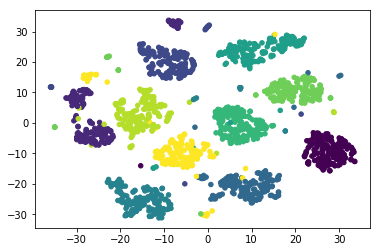

In [111]:
plt.scatter(data_2d[:,0], data_2d[:,1], 20, label)

In [65]:
tf.reset_default_graph()
n = 5
no_dims = 2

Y = tf.get_variable(name = "Y", shape=[n, no_dims],  
                    initializer =tf.random_normal_initializer())

sum_y = tf.reduce_sum(tf.square(Y), 1)
temp = tf.add(tf.transpose(tf.add(-2*tf.matmul(Y, tf.transpose(Y)), sum_y)), sum_y)
num = tf.divide(1,1 + temp)



init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    y = sess.run(Y)
    res = sess.run(num)
print(res)
print(y)

[[0.         0.14764436 0.19822931 0.24899329 0.8401241 ]
 [0.14764436 0.         0.07773452 0.06620658 0.11568879]
 [0.19822931 0.07773452 0.         0.53903073 0.16772479]
 [0.24899332 0.06620658 0.5390307  0.         0.24206233]
 [0.840124   0.11568879 0.16772479 0.24206233 0.        ]]
[[-6.6375798e-01  1.4153293e-01]
 [-1.0055504e+00  2.5198119e+00]
 [ 1.3423599e+00 -4.2939713e-04]
 [ 8.1892943e-01 -7.6279569e-01]
 [-8.7212080e-01 -2.4172336e-01]]


In [47]:
a = np.array([2.0593538, 1.5450652 ])
b = np.array([0.8975018, 0.02564423])
print(1/(1+np.sum((a-b)**2)))

0.2146595214266235
